In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Generating the data

In [2]:
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

### Defining the model

In [3]:
# Exact inference GP.
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        # Can tweak these.
        self.mean_module = gpytorch.means.ConstantMean() 
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# Initialise likelihood and model.
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

### Training

Downside: this uses [empirical Bayes method](https://en.wikipedia.org/wiki/Empirical_Bayes_method), not full Bayesian optimisation, to fit the GP to the data.

In [5]:
training_iter = 50

In [7]:
# Set to train mode.
model.train()
likelihood.train()

# Optimiser.
optimiser = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss": the marginal log-likelihood.
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimiser.zero_grad()
    
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    
    print(f"Iter {i+1}/{training_iter} - Loss: {loss.item():.3f}   length scale: {model.covar_module.base_kernel.lengthscale.item():.3f}    noise: {model.likelihood.noise.item():.3f}")
    
    optimiser.step()

Iter 1/50 - Loss: 0.946   length scale: 0.693    noise: 0.693
Iter 2/50 - Loss: 0.915   length scale: 0.644    noise: 0.644
Iter 3/50 - Loss: 0.880   length scale: 0.598    noise: 0.598
Iter 4/50 - Loss: 0.842   length scale: 0.555    noise: 0.554
Iter 5/50 - Loss: 0.798   length scale: 0.514    noise: 0.513
Iter 6/50 - Loss: 0.748   length scale: 0.475    noise: 0.474
Iter 7/50 - Loss: 0.695   length scale: 0.439    noise: 0.437
Iter 8/50 - Loss: 0.642   length scale: 0.404    noise: 0.402
Iter 9/50 - Loss: 0.591   length scale: 0.372    noise: 0.369
Iter 10/50 - Loss: 0.544   length scale: 0.342    noise: 0.339
Iter 11/50 - Loss: 0.502   length scale: 0.315    noise: 0.310
Iter 12/50 - Loss: 0.464   length scale: 0.292    noise: 0.284
Iter 13/50 - Loss: 0.428   length scale: 0.272    noise: 0.259
Iter 14/50 - Loss: 0.392   length scale: 0.256    noise: 0.236
Iter 15/50 - Loss: 0.358   length scale: 0.242    noise: 0.215
Iter 16/50 - Loss: 0.323   length scale: 0.232    noise: 0.196
I

### Making predictions

In [8]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

### Plotting the model fit

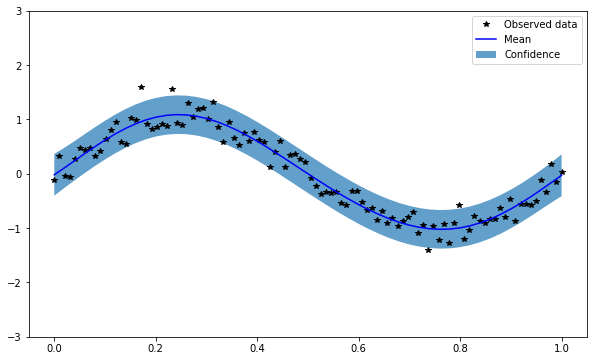

In [9]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(10, 6))
    lower, upper = observed_pred.confidence_region()
    
    ax.plot(train_x.numpy(), train_y.numpy(), "k*")
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), "b") 
    
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.7)
    ax.set_ylim([-3, 3])
    ax.legend(["Observed data", "Mean", "Confidence"])